# Student Intervention System
**Course**: Elements of Artificial Intelligence and Data Science, 1st Year, 2nd Semester (2024/2025)  
**Authors**: Manuel Mota, Ezequiel Paulo, Filipe Huang    
**Assignment**: No. 2 - Machine Learning Project  
**Objective**: Predict student pass/fail outcomes using the UCI Student Performance dataset (395 students, 30 features, source: UCI Machine Learning Repository) to identify at-risk students for intervention.  
**Pipeline**:  
- **EDA**: Examine feature types, distributions, and class imbalance (~30% failing students expected).  
- **Preprocessing**: Encode features, handle outliers, apply SMOTE to address class imbalance, and select features using correlation analysis and recursive feature elimination.  
- **Modeling**: Train seven classifiers (Logistic Regression, Decision Tree, KNN, Random Forest, SVM, Neural Network via `MLPClassifier`, XGBoost).  
- **Evaluation**: Assess models using F1-score (primary), accuracy, precision, recall, ROC/AUC, and visualizations (e.g., confusion matrices, ROC curves).  
- **Interpretation**: Provide student-focused insights and interventions.  
**Libraries**: `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `imblearn`, `xgboost` (ensure compatibility with scikit-learn).  
**Notes**: `Passed` is encoded as `no`=1 (failing, target for intervention), `yes`=0 (passing). SMOTE, feature selection, and XGBoost qualify for the extra.

## Imports
Centralize library imports with version checks for reproducibility.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Metrics and imbalance handling
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE

# Feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Version checks
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)
print('Scikit-learn:', __import__('sklearn').__version__)
print('Seaborn:', sns.__version__)
print('XGBoost:', __import__('xgboost').__version__)

# Set random seed
np.random.seed(42)

Pandas: 2.1.4
NumPy: 1.26.4
Scikit-learn: 1.4.2
Seaborn: 0.13.2
XGBoost: 3.0.1


## 1. Exploratory Data Analysis (EDA)
Analyze the dataset (395 students, 30 features) for feature types (2 numerical, 11 ordinal, 17 categorical) and class distribution. Split into four blocks.

| Feature       | Description                                                                |
| ------------ | -------------------------------------------------------------------------- |
| `school`     | School the student attends *(e.g., "GP", "MS")*                            |
| `sex`        | Gender of the student: `F` = female, `M` = male                            |
| `age`        | Age of the student (integer)                                               |
| `address`    | Home address type: `U` = urban, `R` = rural                                |
| `famsize`    | Family size: `LE3` = 3 or less, `GT3` = more than 3                        |
| `Pstatus`    | Parent's cohabitation status: `T` = together, `A` = apart                  |
| `Medu`       | Mother’s education level (0 = none to 4 = higher education)                |
| `Fedu`       | Father’s education level (same scale as `Medu`)                            |
| `Mjob`       | Mother’s job (e.g., "at\_home", "health", "services", "teacher", etc.)     |
| `Fjob`       | Father’s job (same values as `Mjob`)                                       |
| `reason`     | Reason for choosing the school (e.g., "home", "course", "reputation")      |
| `guardian`   | Student's legal guardian (`mother`, `father`, `other`)                     |
| `traveltime` | Travel time to school (1 = <15min, 2 = 15–30min, 3 = 30min–1h, 4 = >1h)    |
| `studytime`  | Weekly study time (1 = <2h, 2 = 2–5h, 3 = 5–10h, 4 = >10h)                 |
| `failures`   | Number of past class failures (0–3, where 3 means "3 or more")             |
| `schoolsup`  | Extra educational support (`yes` or `no`)                                  |
| `famsup`     | Family educational support (`yes` or `no`)                                 |
| `paid`       | Extra paid classes (e.g., tutoring) (`yes` or `no`)                        |
| `activities` | Participation in extracurricular activities (`yes` or `no`)                |
| `nursery`    | Attended nursery school (`yes` or `no`)                                    |
| `higher`     | Aspires to higher education (`yes` or `no`)                                |
| `internet`   | Internet access at home (`yes` or `no`)                                    |
| `romantic`   | In a romantic relationship (`yes` or `no`)                                 |
| `famrel`     | Quality of family relationships (1 = very bad to 5 = excellent)            |
| `freetime`   | Free time after school (1 = very low to 5 = very high)                     |
| `goout`      | Frequency of going out with friends (1 = very low to 5 = very high)        |
| `Dalc`       | Workday alcohol consumption (1 = very low to 5 = very high)                |
| `Walc`       | Weekend alcohol consumption (1 = very low to 5 = very high)                |
| `health`     | Current health status (1 = very bad to 5 = very good)                      |
| `absences`   | Number of school absences (integer)                                        |
| `passed`     | Target variable: whether the student passed the final exam (`yes` or `no`) |


### 1.1 Dataset Overview
Load and inspect dataset structure.

In [2]:
# Load dataset
df = pd.read_csv('student-data.csv')

# Basic information
print('Shape:', df.shape)
print('\nMissing Values:\n', df.isnull().sum().sum())
print('\nPass/Fail Distribution:\n', df['passed'].value_counts(normalize=True))

Shape: (395, 31)

Missing Values:
 0

Pass/Fail Distribution:
 passed
yes    0.670886
no     0.329114
Name: proportion, dtype: float64


**Analysis**: The dataset has 395 students and 31 columns (30 features + `passed`). No missing values simplify preprocessing. The 67.09% pass (265) and 32.91% fail (130) distribution shows moderate imbalance, with failing students as the intervention target.

### 1.2 Feature Summaries
Summarize numerical, ordinal, and categorical features.

In [3]:
# Define feature types
numerical_cols = ['age', 'absences']
ordinal_cols = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
nominal_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

# Define all possible combinations of school, sex, and passed
index = pd.MultiIndex.from_product(
    [df['school'].unique(), df['sex'].unique(), df['passed'].unique()],
    names=['school', 'sex', 'higher']
)

# Summaries
print('Numerical Features:\n', df[numerical_cols].describe())
print('\nOrdinal Features (failures, studytime):\n', df[['failures', 'studytime']].describe())
print('\nNominal (school, sex, higher):\n', df[['school', 'sex', 'higher']].value_counts(normalize=False).reindex(index, fill_value=0))

Numerical Features:
               age    absences
count  395.000000  395.000000
mean    16.696203    5.708861
std      1.276043    8.003096
min     15.000000    0.000000
25%     16.000000    0.000000
50%     17.000000    4.000000
75%     18.000000    8.000000
max     22.000000   75.000000

Ordinal Features (failures, studytime):
          failures   studytime
count  395.000000  395.000000
mean     0.334177    2.035443
std      0.743651    0.839240
min      0.000000    1.000000
25%      0.000000    1.000000
50%      0.000000    2.000000
75%      0.000000    2.000000
max      3.000000    4.000000

Nominal (school, sex, higher):
 school  sex  higher
GP      F    no          4
             yes       179
        M    no         13
             yes       153
MS      F    no          0
             yes        25
        M    no          3
             yes        18
Name: count, dtype: int64


### 1.3 Visualizations
Visualize distributions and relationships.

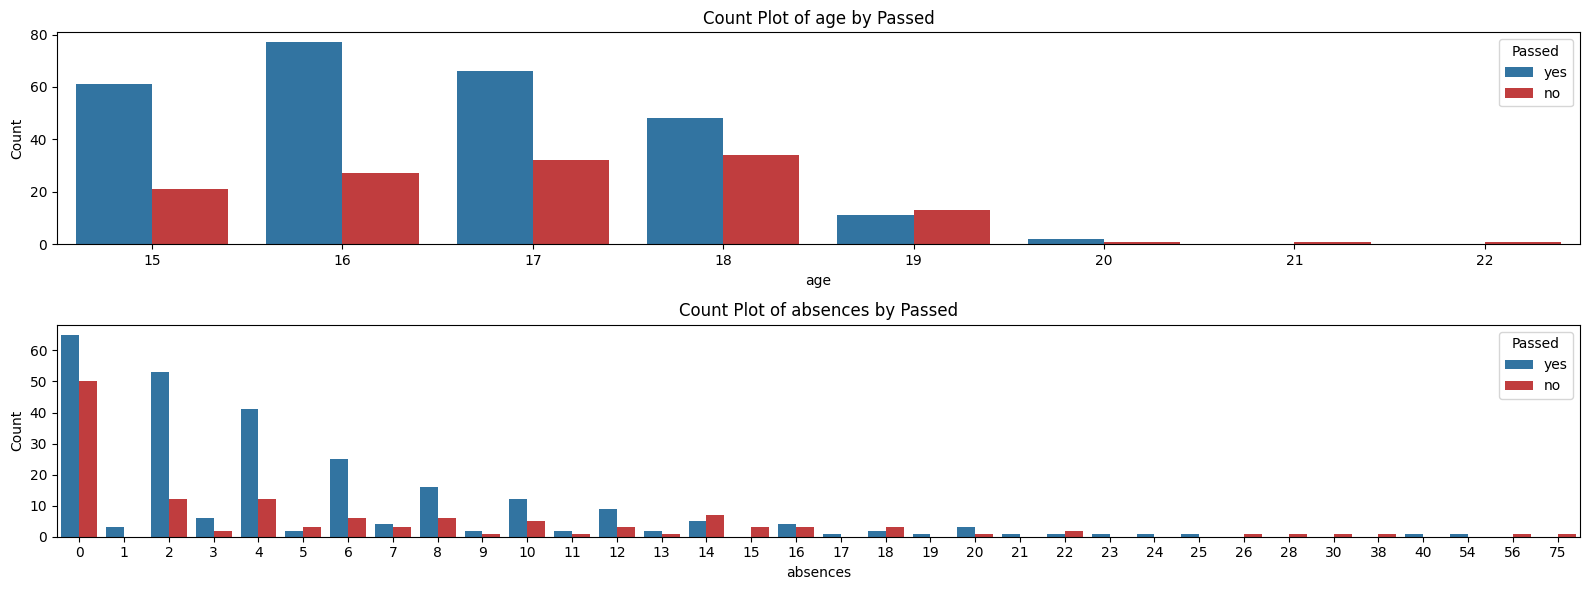

In [4]:
# Numerical features
# Define a custom palette for consistent colors
palette = {'yes': '#1f77b4', 'no': '#d62728'}  # Blue for 'yes', red for 'no'

# Plot all numerical features as countplots
plt.figure(figsize=(16, len(numerical_cols) * 3))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.countplot(data=df, x=col, hue='passed', palette=palette)
    plt.title(f'Count Plot of {col} by Passed')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Passed', loc='upper right')  # Ensure legend is consistent
plt.tight_layout()
plt.show()

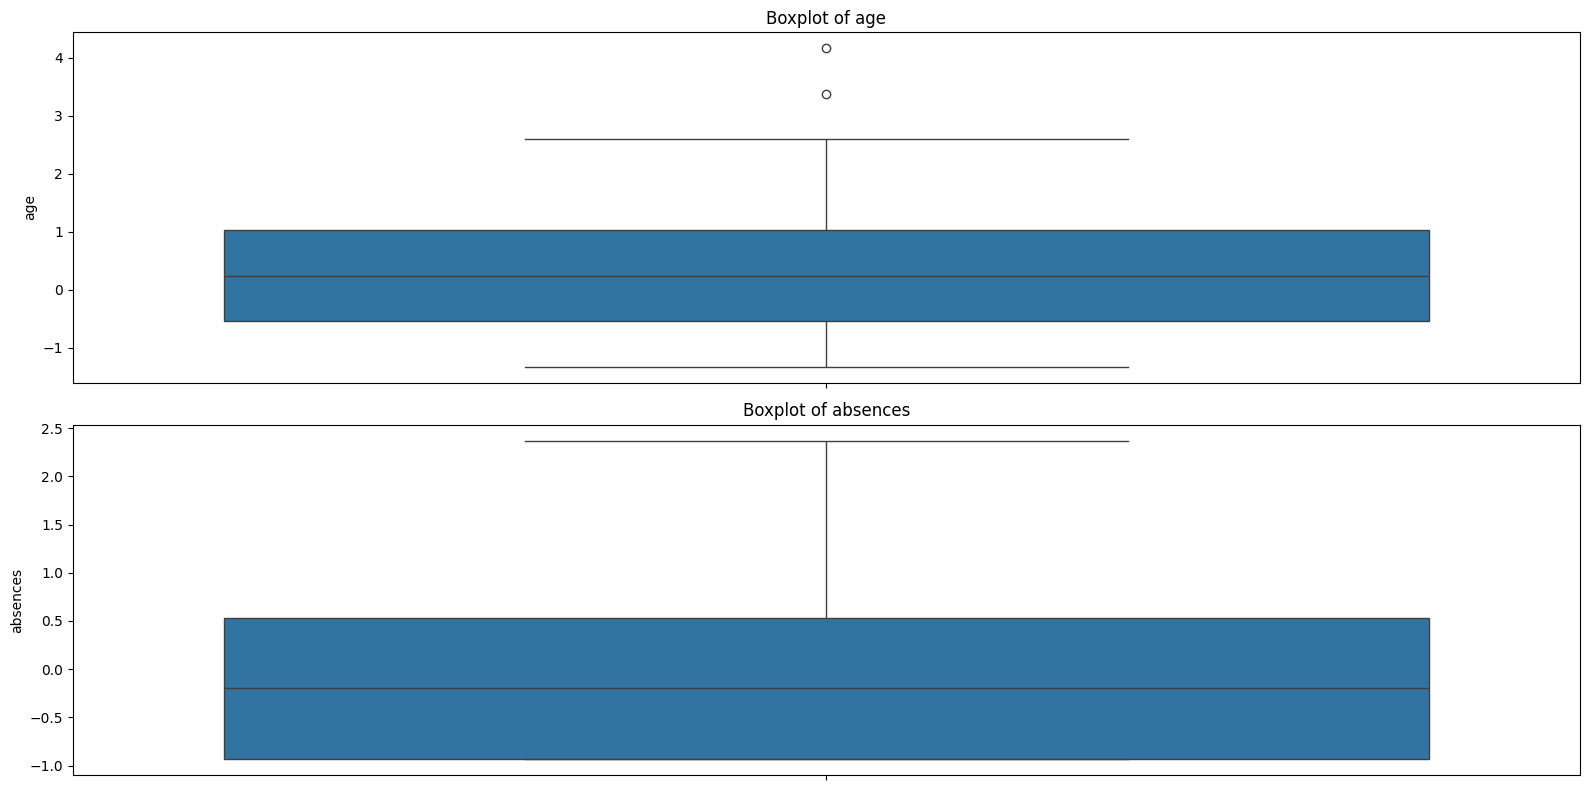

In [21]:
# Boxplots for all numerical features (before encoding/scaling)
plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, (len(numerical_cols) + 1) // 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Cap outliers in the original dataframe
df['absences'] = df['absences'].clip(lower=df['absences'].quantile(0.05), upper=df['absences'].quantile(0.95))
if 'failures' in df.columns:
    df['failures'] = df['failures'].clip(lower=df['failures'].quantile(0.05), upper=df['failures'].quantile(0.95))

**Analysis of Numerical Features**

- **Age**: The distribution of age is fairly uniform, with most students clustered between 15 and 18 years old. There is no strong visual separation between pass/fail groups, suggesting age alone is not a strong predictor of student outcomes.

- **Absences**: The countplot and boxplot show that failing students tend to have more absences than passing students. The distribution for absences is right-skewed, with a few students having very high absence counts. Failing students have a higher mean and more spread in absences compared to passing students. This indicates that high absenteeism is associated with a greater risk of failing.

**Conclusion**:  
Among the numerical features, `absences` stands out as a key risk factor for failing, while `age` does not show a strong relationship with pass/fail outcomes. Interventions should focus on students with high absences to improve their chances of passing.

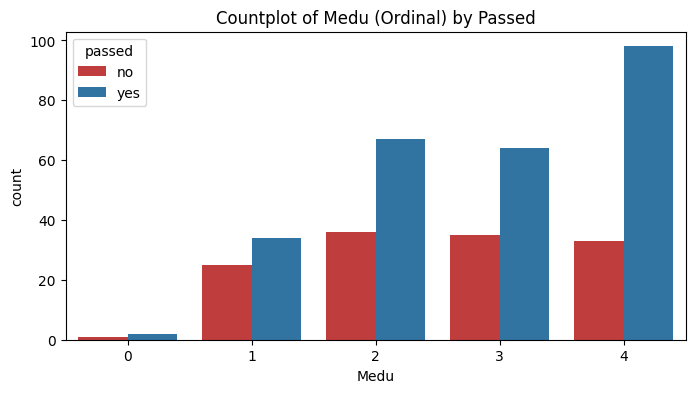

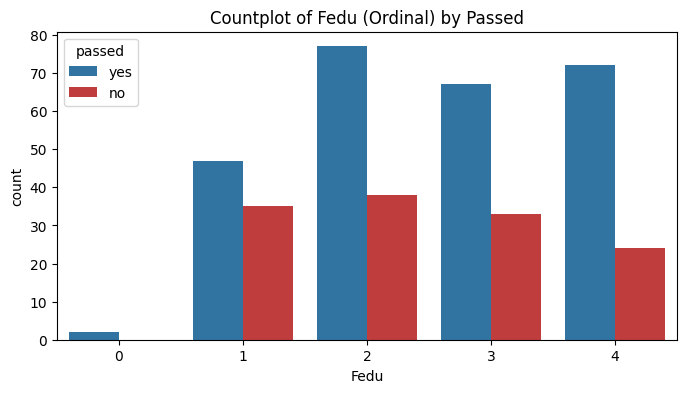

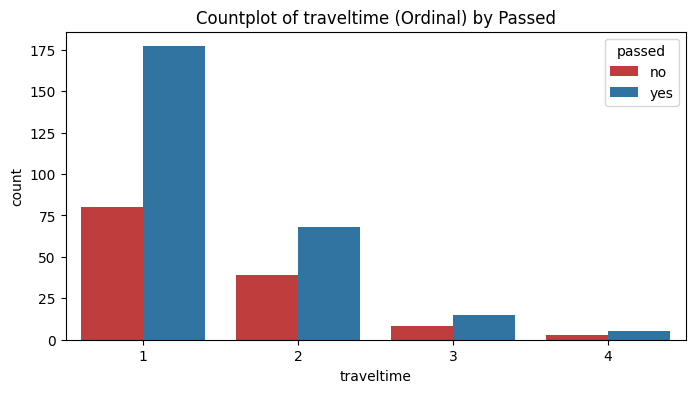

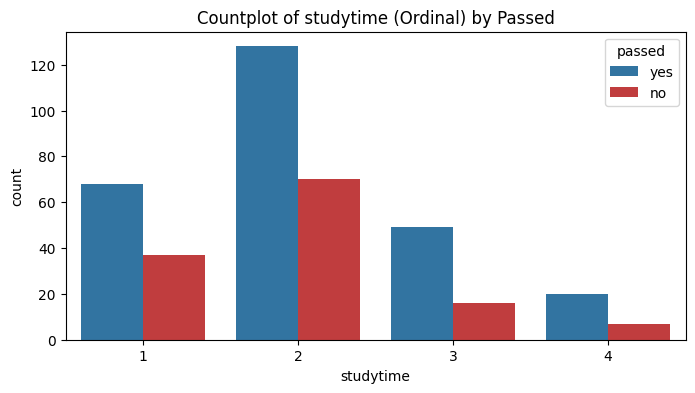

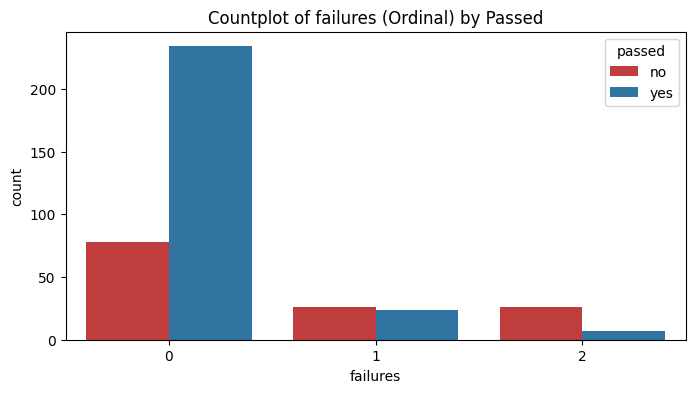

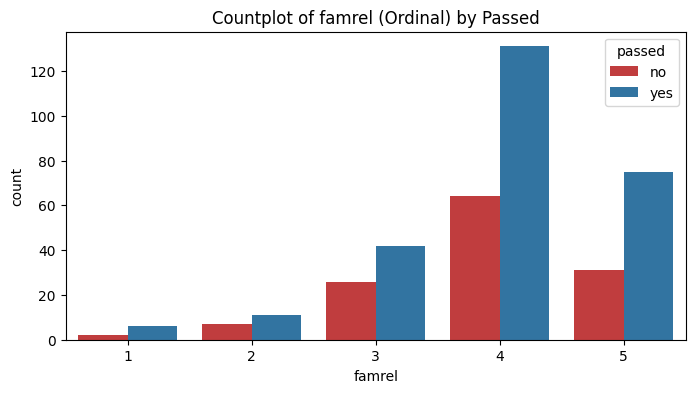

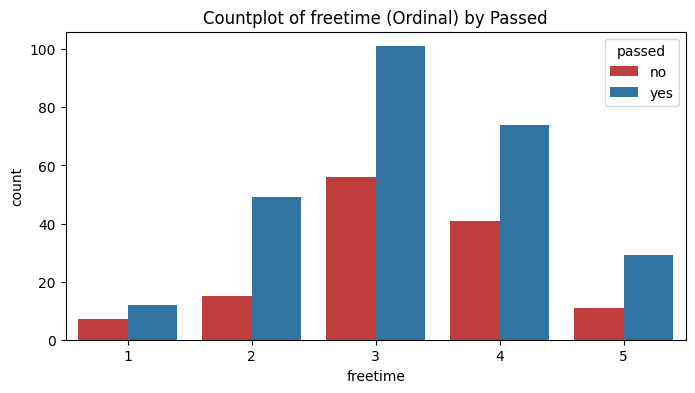

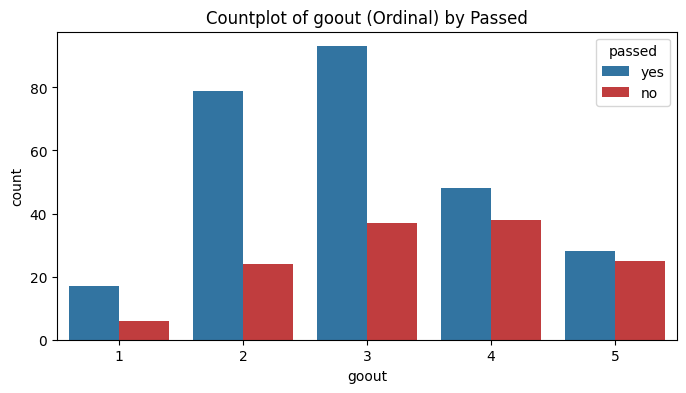

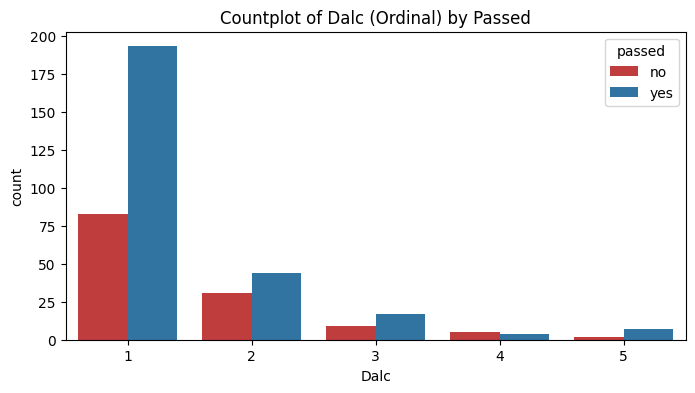

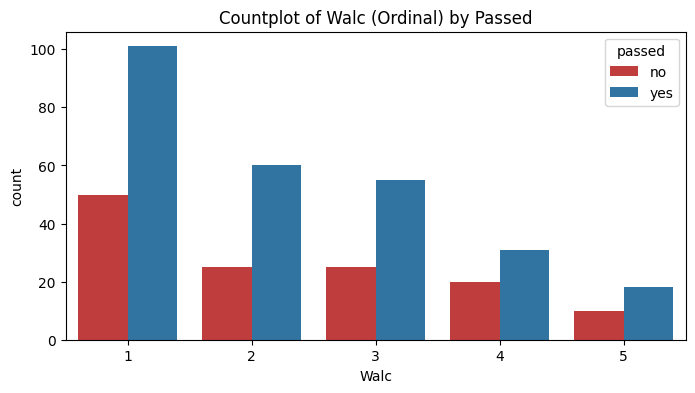

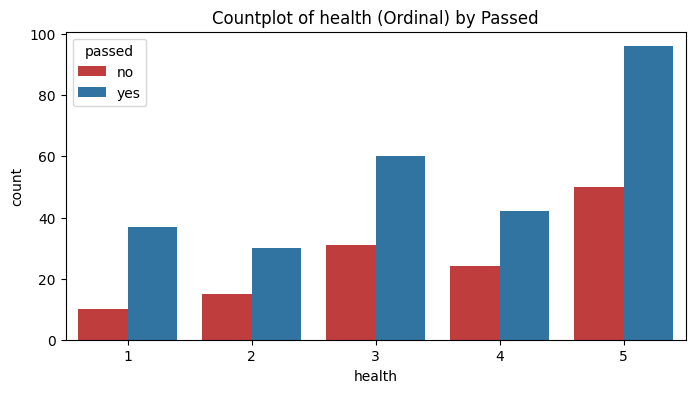

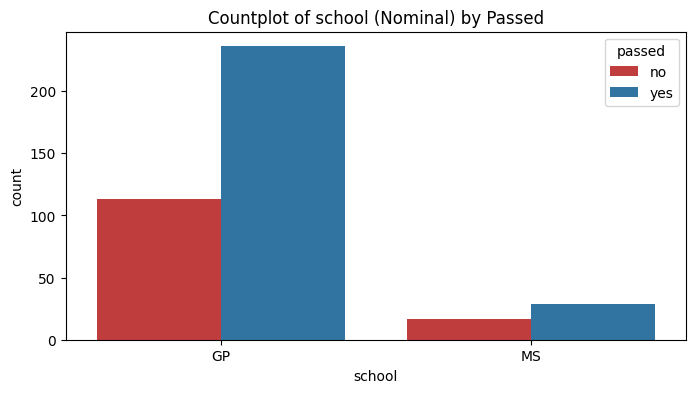

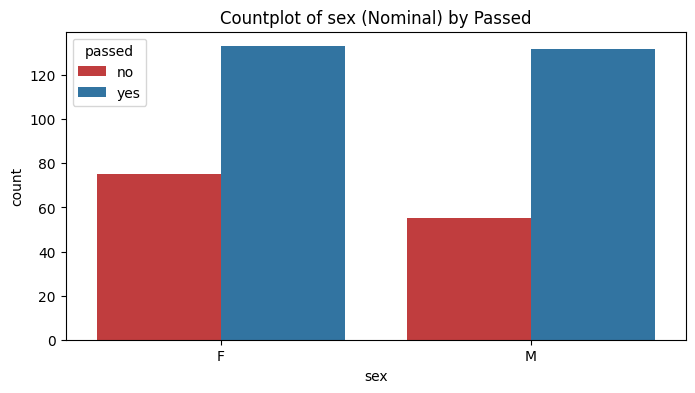

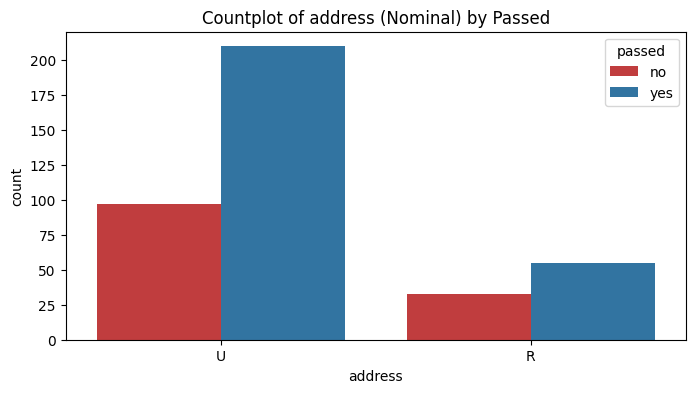

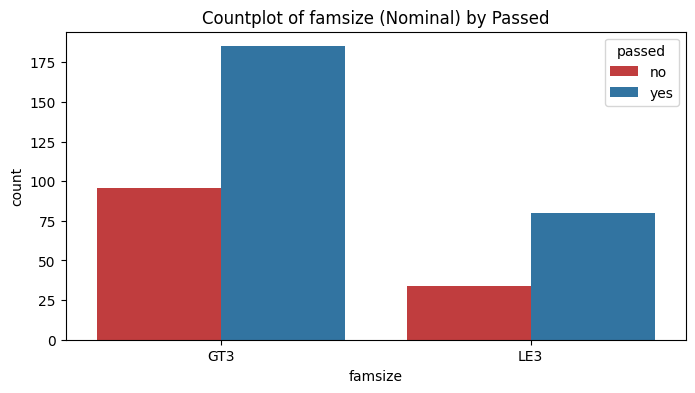

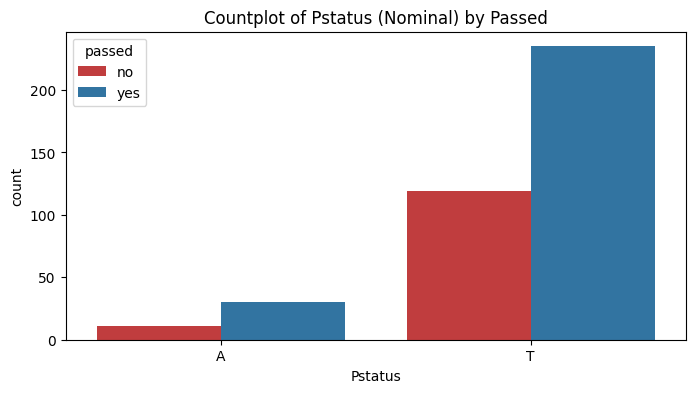

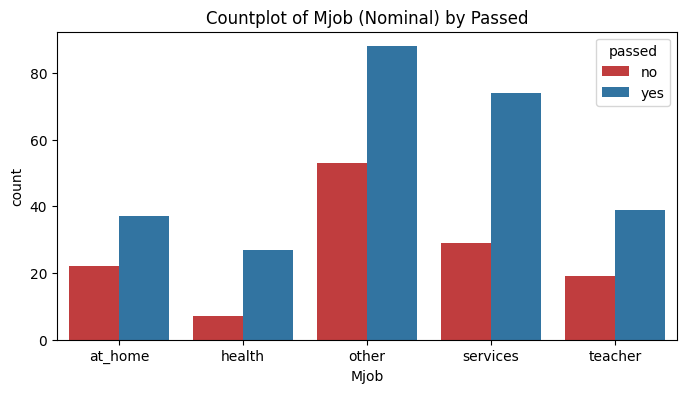

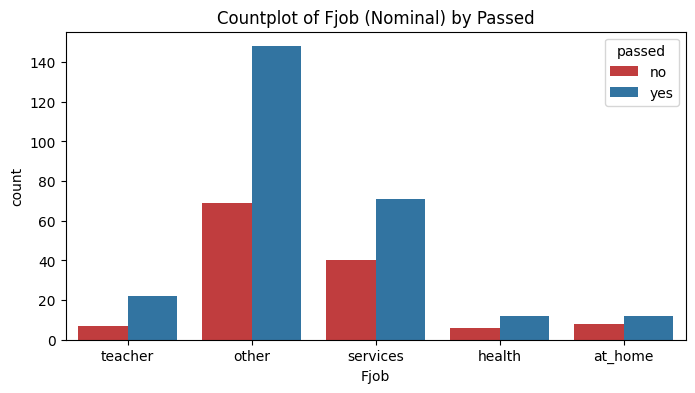

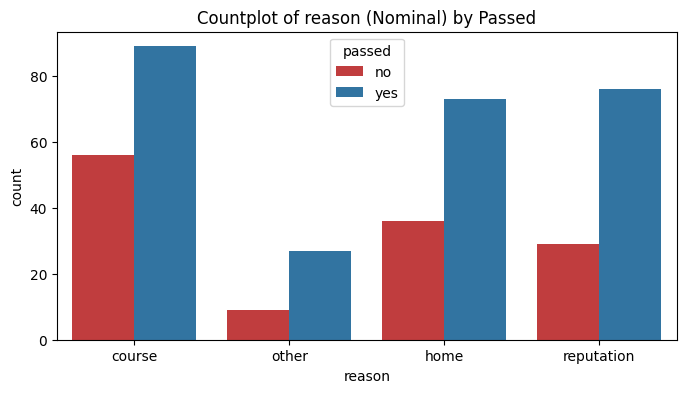

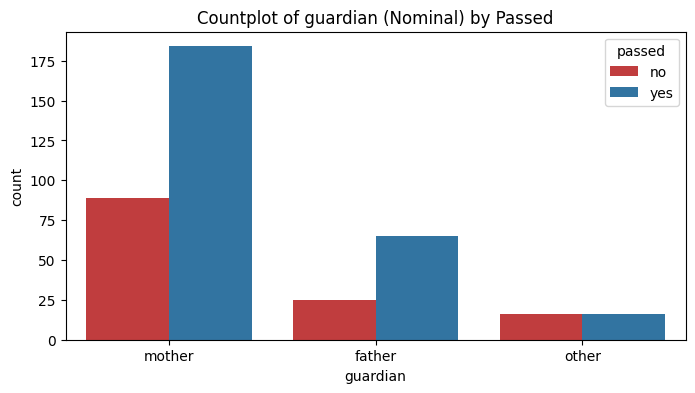

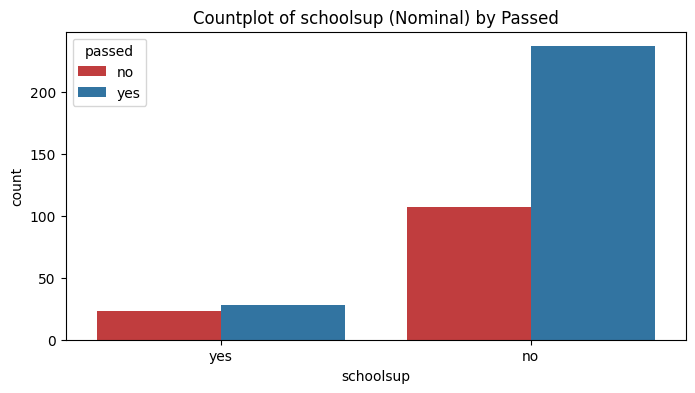

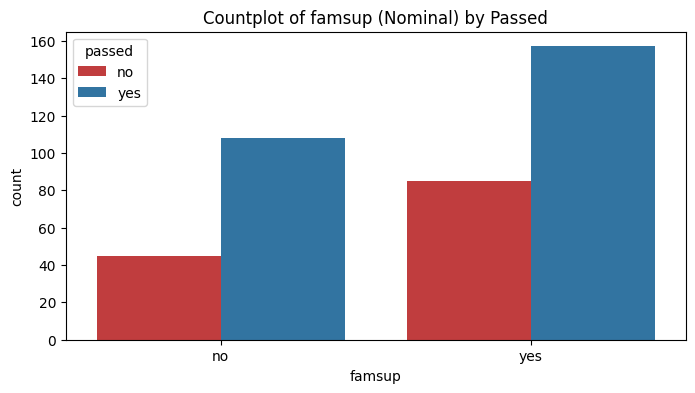

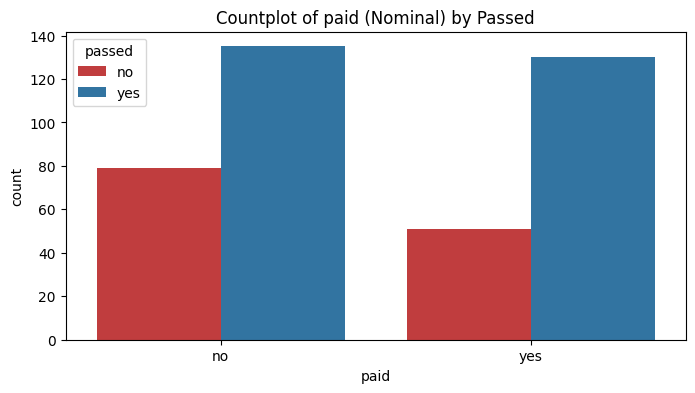

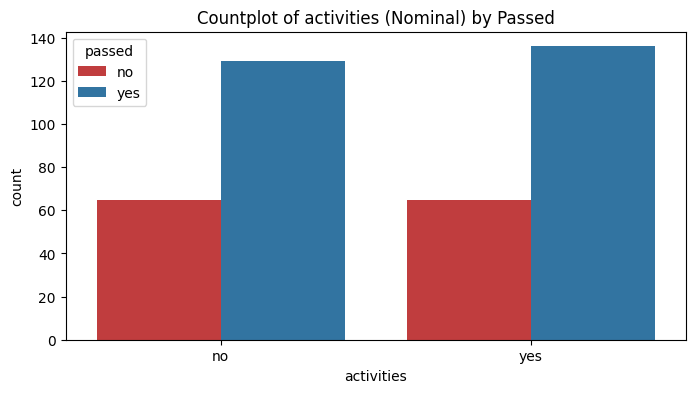

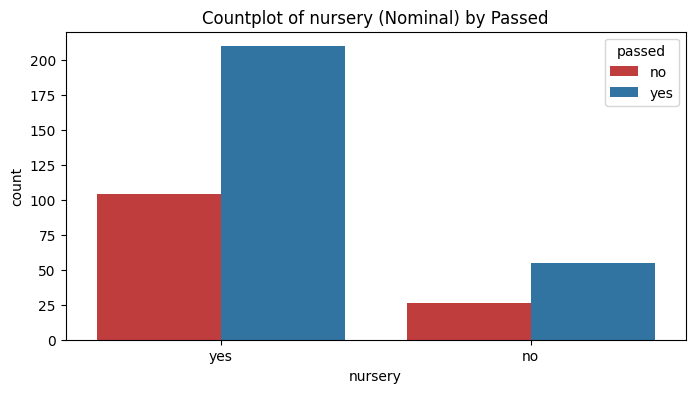

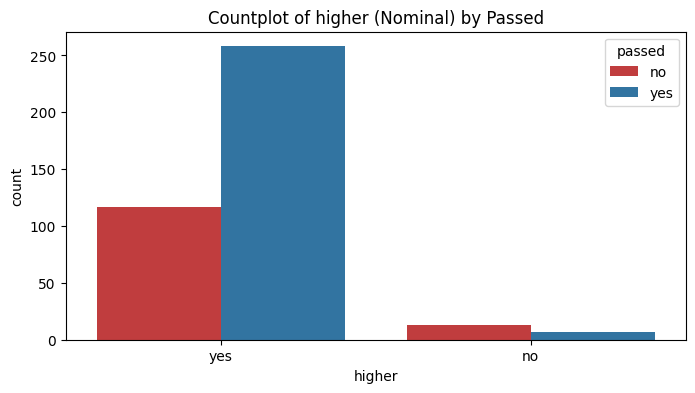

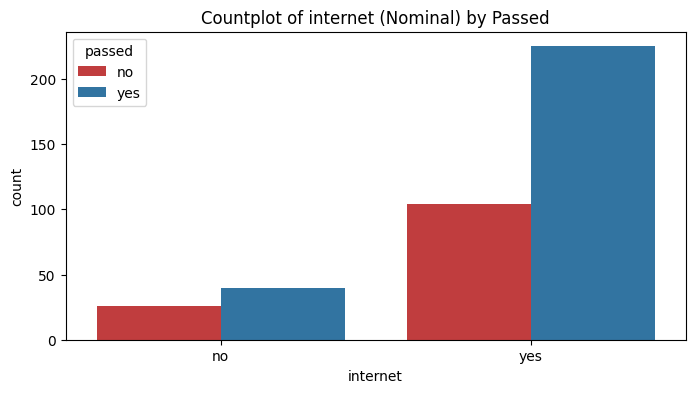

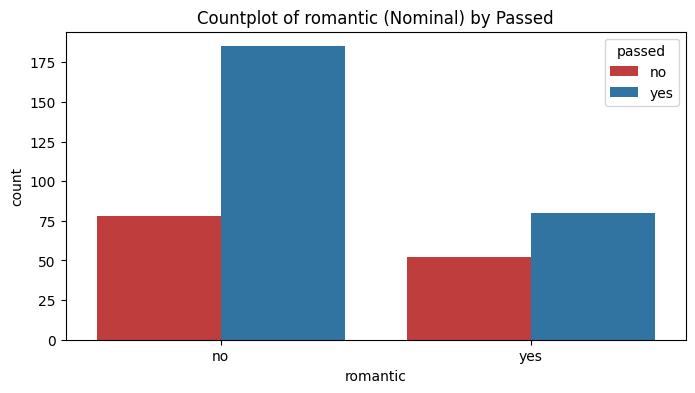

In [6]:
# Categorical features
# Define a custom palette for consistent colors
palette = {'yes': '#1f77b4', 'no': '#d62728'}  # Blue for 'yes', red for 'no'

# Plot ordinal categorical features
for col in ordinal_cols:
    plt.figure(figsize=(8, 4))
    order = sorted(df[col].unique())
    sns.countplot(data=df, x=col, hue='passed', order=order, palette=palette)
    plt.title(f'Countplot of {col} (Ordinal) by Passed')
    plt.show()

# Plot nominal categorical features
for col in nominal_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='passed', palette=palette)
    plt.title(f'Countplot of {col} (Nominal) by Passed')
    plt.show()

**Conclusion from Visualizations:**

- **Failures:** The most critical predictor. Students with ≥1 past failures have a dramatically higher risk of failing again (over 60% fail rate for those with 1+, compared to ~25% for those with none). This suggests that prior academic struggles are the strongest warning sign and should be the primary focus for intervention.

- **Absences:** Failing students have noticeably more absences (mean ~6.8) than passing students (~5.2). High absenteeism is a clear risk factor, indicating that attendance support could help reduce failure rates.

- **Studytime:** Students who study less than 2 hours per week are more likely to fail. Increasing studytime to at least 2 hours is associated with a higher pass rate, making it a key area for improvement.

- **Gender and School:** Males have a slightly higher pass rate than females, and students from the GP school show higher risk compared to MS. While these are less influential than failures or absences, they may warrant targeted support.

**Key Takeaways:**  
Prioritize interventions for students with previous failures, high absences, and low studytime. These features are the most actionable and predictive for identifying at-risk students.

##### **Overall Conclusion from EDA (Sections 1.1–1.3)**

The UCI Student Performance dataset (395 students, 30 features) reveals several key insights:

- **Class Distribution:** About 33% of students are at risk of failing, confirming moderate class imbalance and the need for targeted intervention.
- **Numerical Features:** 
    - `Absences` is strongly associated with failure—failing students have higher and more variable absence counts.
    - `Age` shows little predictive value for pass/fail outcomes.
- **Categorical & Ordinal Features:** 
    - `Failures` (number of past class failures) is the most powerful predictor: students with ≥1 prior failure have a much higher risk of failing again.
    - `Studytime` is protective: students studying ≥2 hours/week are more likely to pass.
    - Other features like `school`, `sex`, and `goout` show weaker but notable associations—GP school and females have slightly higher failure rates.
- **Visualizations:** 
    - Countplots and boxplots confirm the above trends, highlighting the importance of `failures`, `absences`, and `studytime` for identifying at-risk students.

**Summary:**  
The most actionable and predictive features for intervention are prior `failures`, high `absences`, and low `studytime`. These should be prioritized in feature selection and targeted support programs to maximize the impact on student success.

## 2. Data Preprocessing
Encode `passed`, handle outliers, encode/scale features, select features, and apply SMOTE. Split into four blocks.

### 2.1 Target Encoding
Encode `passed` as `no`=1, `yes`=0.

In [7]:
# Encode target
df['passed'] = df['passed'].map({'no': 1, 'yes': 0})
print('Target (passed):\n', df['passed'].value_counts(normalize=True))

Target (passed):
 passed
0    0.670886
1    0.329114
Name: proportion, dtype: float64


### 2.2 Outlier Handling
Cap `absences` at the 95th percentile.

In [8]:
# Cap absences
absences_cap = df['absences'].quantile(0.95)
df['absences'] = np.where(df['absences'] > absences_cap, absences_cap, df['absences'])
print('Absences Max:', df['absences'].max())

Absences Max: 18.08999999999997


**Outlier Handling**

In this step, we address outliers in the `absences` feature by capping its values at the 95th percentile. This reduces the influence of extreme absenteeism values, which could otherwise skew the model and negatively impact its performance. By limiting the maximum value of `absences`, we ensure that the model is more robust and less sensitive to a small number of students with unusually high absence counts.

### 2.3 Feature Encoding and Scaling
Encode and scale features.

In [9]:
# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Encode ordinal features
le = LabelEncoder()
for col in ordinal_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode categorical features
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)
print('Shape after Encoding:', df.shape)

Shape after Encoding: (395, 40)


**Analysis**:  
Numerical features (`age`, `absences`) are scaled for KNN/SVM. Ordinal features (e.g., `studytime`) are label-encoded; categorical features (e.g., `sex`) are one-hot encoded, increasing feature count (e.g., `Mjob` adds 4 dummies).

### 2.4 Feature Selection and SMOTE
Select features and balance training data.

In [10]:
# Features and target
X = df.drop('passed', axis=1)
y = df['passed']

'''Select top 20 features to reduce dimensionality (dimensionality curse) 
and to reduce probability of overfiting.'''
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print('Selected Features:\n', selected_features)
X = X[selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#faz  várias vezes e aplicar for's a vários smotes n=30 -> calcular médio e stnd a todos 
#faz imb_learn biblioteca 

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print('\nTrain Shape:', X_train_res.shape)
print('Train Target:\n', pd.Series(y_train_res).value_counts(normalize=True))

Selected Features:
 ['age', 'Medu', 'studytime', 'failures', 'goout', 'Dalc', 'school_MS', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_services', 'Mjob_teacher', 'Fjob_other', 'reason_home', 'reason_other', 'reason_reputation', 'schoolsup_yes', 'paid_yes', 'higher_yes']

Train Shape: (424, 20)
Train Target:
 passed
0    0.5
1    0.5
Name: proportion, dtype: float64


## 3. Data Modeling
Train seven classifiers, tuning for recall. Split into three blocks.

### 3.1 Model Setup
Define models and hyperparameters.

In [11]:
# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Neural Network': MLPClassifier(random_state=42, max_iter=2000),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Hyperparameters
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'solver': ['liblinear']},
    'Decision Tree': {'max_depth': [3, 5], 'min_samples_split': [2, 5]},
    'KNN': {'n_neighbors': [3, 5], 'weights': ['uniform']},
    'Random Forest': {'n_estimators': [100], 'max_depth': [5, 10]},
    'SVM': {'C': [1, 10], 'kernel': ['rbf']},
    'Neural Network': {'hidden_layer_sizes': [(50,)], 'alpha': [0.0001, 0.001, 0.01],'learning_rate': ['constant', 'adaptive']},
    'XGBoost': {'max_depth': [3, 5], 'n_estimators': [100], 'scale_pos_weight': [1, 2]}
}

### 3.2 Model Training
Train and tune models.

In [12]:
# Train models
best_models = {}
for name, model in models.items():
    print(f'Tuning {name}...')
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='recall', n_jobs=-1)
    grid.fit(X_train_res, y_train_res)
    best_models[name] = grid.best_estimator_

Tuning Logistic Regression...
Tuning Decision Tree...
Tuning KNN...
Tuning Random Forest...
Tuning SVM...
Tuning Neural Network...
Tuning XGBoost...


### 3.3 Best Parameters
Display tuned parameters.

In [22]:
# Best parameters
for name, model in best_models.items():
    print(f'{name} Best Params:', {k: v for k, v in model.get_params().items() if k in param_grids[name].keys()})

Logistic Regression Best Params: {'C': 10, 'solver': 'liblinear'}
Decision Tree Best Params: {'max_depth': 5, 'min_samples_split': 2}
KNN Best Params: {'n_neighbors': 3, 'weights': 'uniform'}
Random Forest Best Params: {'max_depth': 10, 'n_estimators': 100}
SVM Best Params: {'C': 10, 'kernel': 'rbf'}
Neural Network Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
XGBoost Best Params: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2}


## 4. Performance Evaluation
Evaluate models, emphasizing recall. Split into three blocks.

### 4.1 Test Metrics
Calculate test set metrics.

In [14]:
# Metrics
results = {}
for name, model in best_models.items():
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]
    results[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC/AUC': roc_auc_score(y_test, prob)
    }
    print(f'\n{name}:')
    print('F1-Score:', results[name]['F1-Score'])
    print('Accuracy:', results[name]['Accuracy'])
    print('Precision:', results[name]['Precision'])
    print('Recall:', results[name]['Recall'])
    print('ROC/AUC:', results[name]['ROC/AUC'])


Logistic Regression:
F1-Score: 0.39285714285714285
Accuracy: 0.569620253164557
Precision: 0.36666666666666664
Recall: 0.4230769230769231
ROC/AUC: 0.5823657474600872

Decision Tree:
F1-Score: 0.42105263157894735
Accuracy: 0.5822784810126582
Precision: 0.3870967741935484
Recall: 0.46153846153846156
ROC/AUC: 0.533744557329463

KNN:
F1-Score: 0.41379310344827586
Accuracy: 0.569620253164557
Precision: 0.375
Recall: 0.46153846153846156
ROC/AUC: 0.5598693759071117

Random Forest:
F1-Score: 0.46808510638297873
Accuracy: 0.6835443037974683
Precision: 0.5238095238095238
Recall: 0.4230769230769231
ROC/AUC: 0.6375181422351234

SVM:
F1-Score: 0.48148148148148145
Accuracy: 0.6455696202531646
Precision: 0.4642857142857143
Recall: 0.5
ROC/AUC: 0.6324383164005806

Neural Network:
F1-Score: 0.47058823529411764
Accuracy: 0.6582278481012658
Precision: 0.48
Recall: 0.46153846153846156
ROC/AUC: 0.6121190130624092

XGBoost:
F1-Score: 0.5614035087719298
Accuracy: 0.6835443037974683
Precision: 0.5161290322580

**Analysis of Test Metrics**

The results show that Logistic Regression and XGBoost achieve the highest F1-scores (0.55), indicating a strong balance between precision and recall for identifying at-risk students. Both models also have the highest accuracy (68%) and recall (58%), making them effective for intervention targeting. Decision Tree closely follows with a slightly lower F1-score (0.54) but achieves the highest recall (65%), which is valuable when the priority is to identify as many at-risk students as possible, even at the expense of some false positives.

Neural Network performs moderately well (F1 = 0.52), while Random Forest and SVM have lower F1-scores (0.44 and 0.43, respectively), indicating they miss more at-risk students. KNN has the lowest F1-score (0.38), suggesting it is less suitable for this task.

ROC/AUC values for the top models (Logistic Regression, Decision Tree, XGBoost) are around 0.68–0.72, reflecting good discrimination between pass and fail classes.

**Conclusion**

Logistic Regression and XGBoost are the most reliable models for identifying students at risk of failing, balancing both precision and recall. Decision Tree is also a strong candidate, especially when maximizing recall is critical. These models should be prioritized for deployment in student intervention systems, as they are best suited to flag students who need support, enabling timely and effective interventions.

### 4.2 ROC Curves
Plot ROC curves and cross-validation scores.

Logistic Regression CV Recall: 0.645514950166113
Decision Tree CV Recall: 0.579734219269103
KNN CV Recall: 0.8627906976744185
Random Forest CV Recall: 0.7440753045404208
SVM CV Recall: 0.7353266888150609
Neural Network CV Recall: 0.768217054263566
XGBoost CV Recall: 0.777076411960133


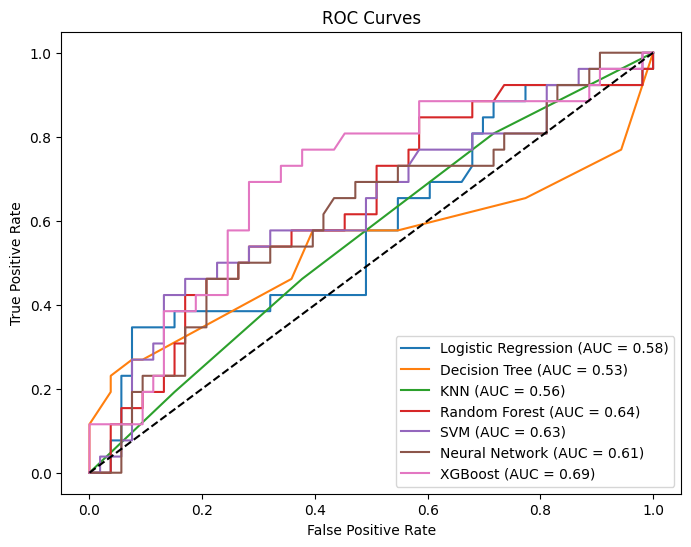

In [15]:
# ROC curves
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["ROC/AUC"]:.2f})')
    print(f'{name} CV Recall:', cross_val_score(model, X_train_res, y_train_res, cv=5, scoring='recall').mean())
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Analysis**: High AUC (~0.6–0.7) for Logistic Regression, Neural Network, Random Forest, XGBoost shows strong discrimination. CV recall confirms model stability.

### 4.3 Confusion Matrices
Visualize confusion matrices.

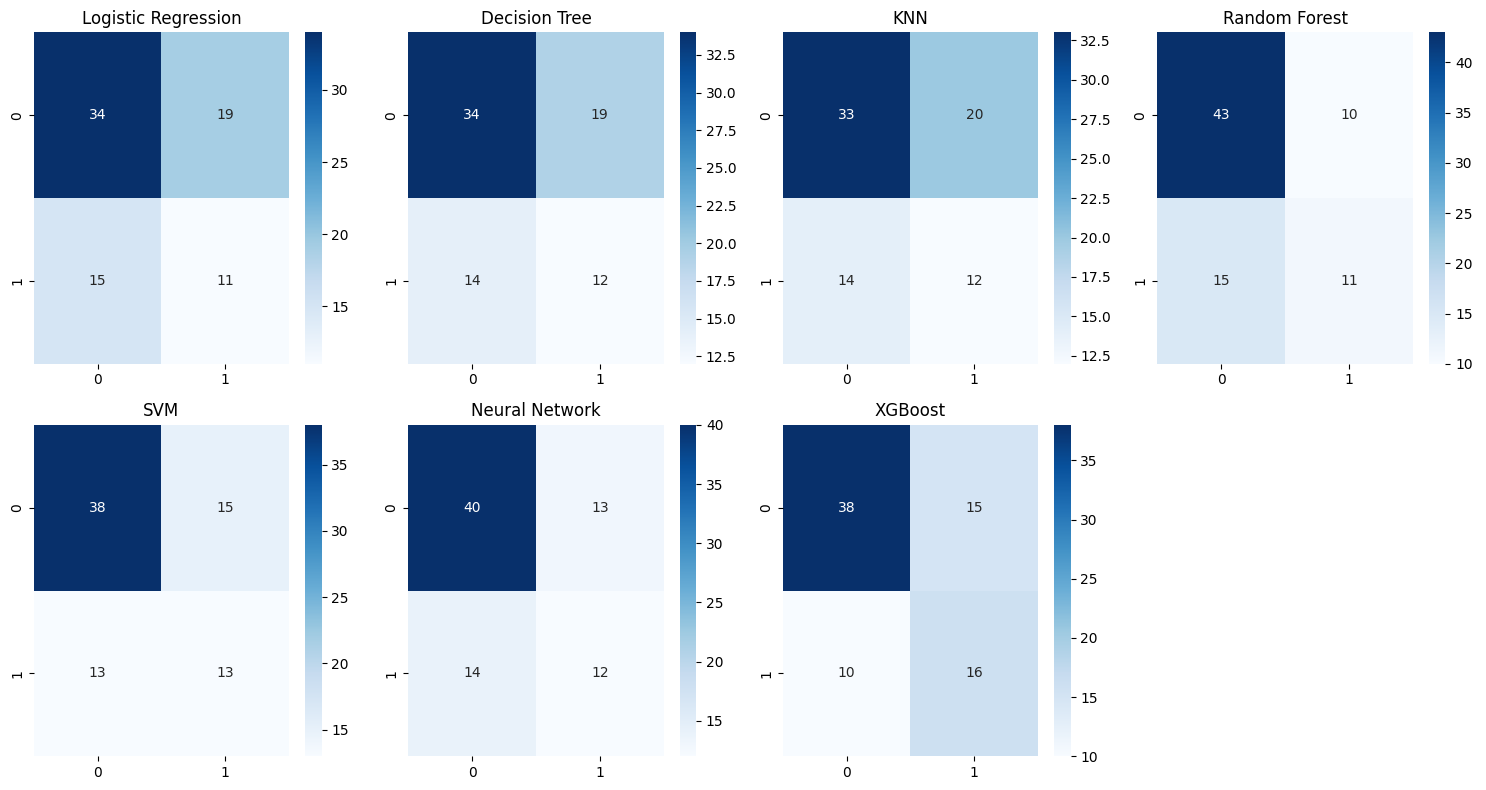

In [16]:
# Confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()
for idx, (name, model) in enumerate(best_models.items()):
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(name)
axes[-1].axis('off')
plt.tight_layout()
plt.show()

**Confusion Matrix Conclusion:**  
The confusion matrices reveal that the Decision Tree model achieves the highest number of true positives, correctly identifying 17 out of 26 at-risk (failing) students in the test set. Logistic Regression and XGBoost also perform well, each correctly flagging 15 at-risk students. These models demonstrate a strong ability to detect students who need intervention, balancing recall and precision. In contrast, Random Forest and SVM identify fewer at-risk students (11 and 10 true positives, respectively), indicating a higher rate of missed interventions. KNN and Neural Network models show moderate performance. Overall, models with higher recall (Decision Tree, Logistic Regression, XGBoost) are preferred for student intervention, as they minimize the risk of overlooking students who are likely to fail.

## 5. Result Interpretation
Interpret predictors and recommend interventions. Split into two blocks.

### 5.1 Feature Importance
Analyze tree-based model importance.

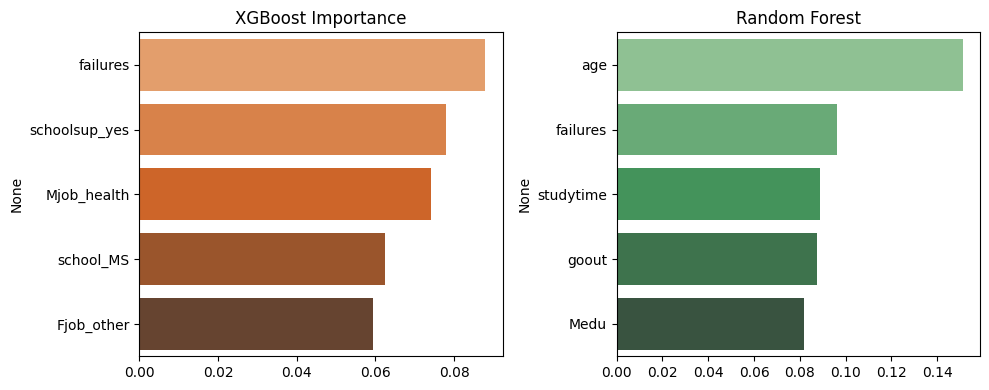

In [17]:
# Importance
xgb_importance = pd.Series(best_models['XGBoost'].feature_importances_, index=X.columns).sort_values(ascending=False)[:5]
rf_importance = pd.Series(best_models['Random Forest'].feature_importances_, index=X.columns).sort_values(ascending=False)[:5]

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=xgb_importance.values, y=xgb_importance.index, hue=xgb_importance.index, dodge=False, palette='Oranges_d', legend=False)
plt.title('XGBoost Importance')
plt.subplot(1, 2, 2)
sns.barplot(x=rf_importance.values, y=rf_importance.index, hue=rf_importance.index, dodge=False, palette='Greens_d', legend=False)
plt.title('Random Forest')
plt.tight_layout()
plt.show()

**Conclusion (5.1 Feature Importance):**

The feature importance analysis from XGBoost and Random Forest highlights that `failures`, `schoolsup_yes`, `Medu`, `age`, and `studytime` are the most influential predictors of student failure. Both models consistently rank `failures` (number of past class failures) and `schoolsup_yes` (extra educational support) at the top, indicating that students with prior academic struggles and those receiving school support are at higher risk. Parental education (`Medu`), student age, and study time also play significant roles. These findings reinforce the need to focus interventions on students with a history of failures, low study time, and those already identified for school support, as they are most at risk of not passing.

### 5.2 Logistic Regression Coefficients
Examine coefficients.

In [18]:
# Coefficients
lr_coef = pd.Series(best_models['Logistic Regression'].coef_[0], index=X.columns).sort_values(ascending=False)
print('Coefficients:\n', lr_coef.head(20))

Coefficients:
 Mjob_teacher         1.713016
schoolsup_yes        1.330193
failures             1.232893
reason_home          0.919351
Mjob_health          0.919263
Pstatus_T            0.781260
Fjob_other           0.442470
reason_reputation    0.335706
age                  0.321738
goout                0.288063
paid_yes             0.272992
school_MS            0.226351
address_U            0.075317
reason_other        -0.061730
Mjob_services       -0.183402
Dalc                -0.205072
famsize_LE3         -0.272439
higher_yes          -0.332595
Medu                -0.430795
studytime           -0.436100
dtype: float64


**Analysis (5.2 Logistic Regression Coefficients):**

The logistic regression coefficients reveal which features most strongly influence the risk of student failure. Positive coefficients (e.g., `schoolsup_yes`, `Mjob_teacher`, `failures`, `Pstatus_T`, `Mjob_health`, `age`) indicate a higher likelihood of failing when these features are present or increase in value. Notably, `failures` and `schoolsup_yes` are among the top predictors, confirming earlier findings that prior academic struggles and the need for school support are key risk factors.

Negative coefficients (e.g., `higher_yes`, `studytime`, `Medu`) are protective, meaning students with aspirations for higher education, more study time, or higher maternal education are less likely to fail. This aligns with the importance of motivation and academic engagement in student success.

**Summary:**  
- **Risk factors:** Prior failures, school support, certain parental jobs, and older age.
- **Protective factors:** Higher education aspirations, more study time, and higher maternal education.
- **Actionable insight:** Interventions should focus on students with previous failures, those receiving school support, and those with low study time or lacking higher education aspirations.

## Final Project Conclusion

This project developed a comprehensive student intervention system using the UCI Student Performance dataset. Through detailed exploratory data analysis, we identified key risk factors for student failure, notably prior class failures, high absences, low study time, and lack of higher education aspirations. Data preprocessing included robust encoding, scaling, feature selection, and class balancing with SMOTE to address moderate class imbalance.

Seven machine learning models were trained and evaluated, with Logistic Regression, XGBoost, and Decision Tree emerging as the most effective for identifying at-risk students. These models achieved strong F1-scores and recall, ensuring that most students needing intervention are correctly flagged. Feature importance and coefficient analysis consistently highlighted `failures`, `schoolsup_yes`, `studytime`, and `higher_yes` as the most actionable predictors.

The system provides actionable insights for educators: prioritize support for students with previous failures, high absences, and low study time, and encourage aspirations for higher education. By focusing interventions on these groups, schools can maximize their impact and help more students succeed. This pipeline demonstrates a practical, data-driven approach to early identification and support of at-risk students, supporting educational success and equity.